In [1]:
import numpy as np
import cv2
import torch.nn as nn
import sudoku
from digits import load_model, predict

In [ ]:
# Load the Pytorch model
file = 'digits_20250410195037_9984.pth'
model = load_model(f"./models/{file}")

In [ ]:
# Load a sample sudoku image
file_path = './samples/sudoku_01.jpg'
image = cv2.imread(file_path)

In [4]:
def recognize_digits_pytorch(grid_image: np.ndarray, model: nn.Module) -> np.ndarray:
    # Digit 1 to 9 [[counter, probability_sum], ...]
    stats = [[0, 0] for _ in range(9)]
    arr = np.zeros((9,9), dtype=np.uint8)
    cells = sudoku.extract_cells(grid_image)
    for row in range(9):
        for col in range(9):
            cell = cells[row, col]
            if not sudoku.is_empty_cell(cell):
                pred_digit, probability = predict(cell, model)
                stats[int(pred_digit)-1][0] += 1
                stats[int(pred_digit)-1][1] += probability.item()
                arr[row, col] = pred_digit
    return arr, stats

In [ ]:
# size=9*50=450, the output size of a sudoku grid image is 450x450 
sudoku_grid = sudoku.extract_grid(image, size=9*50)
if sudoku_grid is not None:
    puzzle, stats = recognize_digits_pytorch(sudoku_grid, model)
    print("Total predictions   :", sum([x[0] for x in stats]))
    print("Occurrences         : ", end='')
    count_of_digits = [x[0] for x in stats]
    for digit, occurrences in enumerate(count_of_digits, start=1):
        print(f"{digit}({occurrences})  ", end='')
    print()
    print("Average probability : ", end='')
    average_probabilities = [x[1]/x[0] if x[0]!=0 else 0 for x in stats]
    for digit, average_probability in enumerate(average_probabilities, start=1):
        print(f"{digit}({average_probability:.3f})  ", end='')
    print("\n")
    for row in puzzle:
        formatted_row = ' '.join(['.' if value == 0 else str(value) for value in row])
        print(formatted_row)
else:
    print(f"Can't extract sudoku grid!")

Total predictions   : 33
Occurrences         : 1(5)  2(2)  3(2)  4(3)  5(4)  6(3)  7(5)  8(5)  9(4)  
Average probability : 1(1.000)  2(1.000)  3(1.000)  4(1.000)  5(1.000)  6(1.000)  7(1.000)  8(1.000)  9(1.000)  

8 . . . 1 . . . 9
. 5 . 8 . 7 . 1 .
. . 4 . 9 . 7 . .
. 6 . 7 . 1 . 2 .
5 . 8 . 6 . 1 . 7
. 1 . 5 . 2 . 9 .
. . 7 . 4 . 6 . .
. 8 . 3 . 9 . 4 .
3 . . . 5 . . . 8


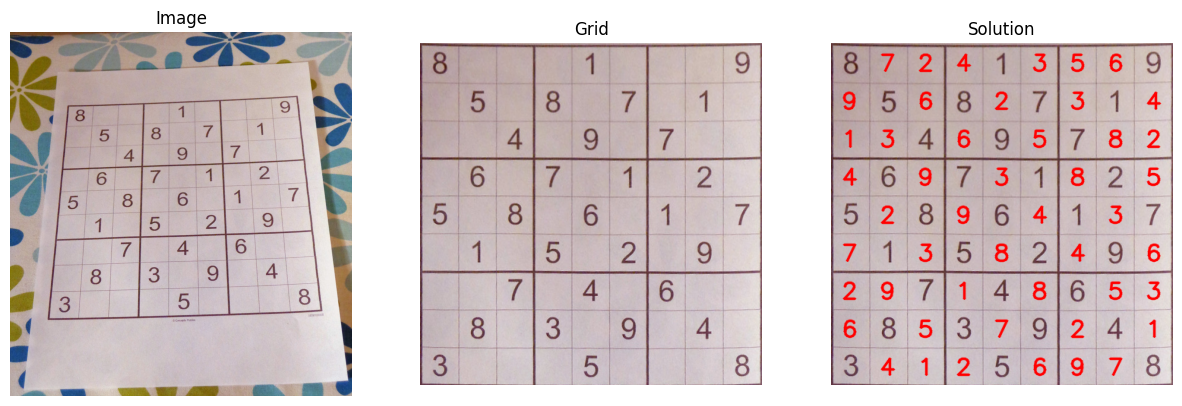

In [6]:
if sudoku_grid is not None:
    puzzle_copy = puzzle.copy()
    if sudoku.solve(puzzle):
        solution = sudoku.get_solution(puzzle_copy, puzzle)
        sudoku_grid_copy = sudoku_grid.copy()
        sudoku.draw_solution(sudoku_grid, solution, (0,0,255))
        sudoku.demonstrate(image, sudoku_grid_copy, sudoku_grid, titles=['Image', 'Grid', 'Solution'], size=(15, 10))
    else:
        print("Puzzle is unsolvable!")